In [20]:
from sbcbinaryformat import Streamer, Writer
import numpy as np
import matplotlib.pyplot as plt

from GetEvent import GetEvent

from ana import AcousticT0 
from scipy.signal import firwin, filtfilt
from scipy.optimize import least_squares
import importlib

In [21]:
importlib.reload(AcousticT0)

<module 'ana.AcousticT0' from '/exp/e961/app/users/runze/projects/LAr10Ana/ana/AcousticT0.py'>

In [22]:
TEST_RUN = "/exp/e961/data/SBC-25-daqdata/20250611_1/"
TEST_RUN2 = "/exp/e961/app/users/runze/data/20251121_5/"
TEST_RUN2 = "/exp/e961/app/users/runze/data/20260205_6/" # quiet mode p=2bara

# TEST_RUN2 = "/exp/e961/data/users/gputnam/SBC-25-daqdata-test/20251103_1/"
TEST_EVT = 31
# 68 is first outlier, 39 is first missing event

In [23]:
data = GetEvent(TEST_RUN2, TEST_EVT,strictMode=False)
# data.keys()

In [24]:
data["cam"].keys()

dict_keys(['loaded', 'c1', 'c2', 'c3'])

In [25]:
data["acoustics"].keys()

dict_keys(['loaded', 'Range', 'DCOffset', 'Waveforms', 'sample_rate'])

In [26]:
data["acoustics"]["Range"]


array([[ 2000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]],
      dtype=int16)

In [27]:
wvfs = data["acoustics"]["Waveforms"]
wvfs.shape

(1, 8, 1300001)

In [28]:
np.float64([[1e2, 1e3, 1e4, 1e5]]).shape

(1, 4)

In [29]:
# plot the first triggered waveform in each channel
# if channel 7 raw reading is ADC -35/1e4
# if channel 7 raw reading is bits, -35/2**15
# MB.PT1101 := AIn.PT1101 * (-35.0* el3052bits);
wvfs_psi = wvfs*(-35/2**16)


In [30]:
piezo0 = wvfs_psi[0, 7, :]
xlimit = [0, 800]
ylimit = [-22.5,-20]
ylimit = [-20,-18]
# first check if the expansion success
average_window_expansion = 100
start_pressure = np.mean(piezo0[:average_window_expansion])
end_pressure = np.mean(piezo0[600000:600000+average_window_expansion])
if start_pressure-end_pressure<0.5:
    print(True)
else:
    print(False)

True


In [31]:
average_window = 50 # every 100 data, do the average
n_chunked = (len(piezo0) // average_window) * average_window # chunk data
piezo0 = piezo0[:n_chunked]

# time in miliseconds
total_time = len(piezo0)
time_list_ms = [i/1e3 for i in range(0,total_time,1)]
time_list_ms  = np.array(time_list_ms[:n_chunked])

piezo0 = piezo0.reshape(-1, average_window).mean(axis=1)
time_list_ms = time_list_ms.reshape(-1,average_window).mean(axis=1)

time length 26000


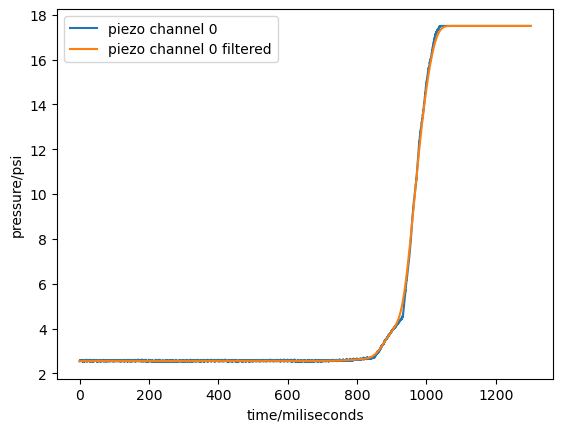

In [32]:
print("time length", len(time_list_ms))
# add low pass filter
# assuming 1 microsecond time resolution 1e6Hz
numtaps = 1000  # filter length (longer = sharper cutoff)
Fs= 1000000/average_window # sampling rate
Fc = 10 # low pass filter in Hz
fir = firwin(numtaps, Fc, window='hamming', fs=Fs)

piezo0_filtered = filtfilt(fir, [1.0], piezo0)
piezoslope0 = (+piezo0_filtered[1:]-piezo0_filtered[:-1])*1e3 # in bar/ms
plt.plot(time_list_ms,piezo0, label="piezo channel 0")
plt.plot(time_list_ms,piezo0_filtered, label="piezo channel 0 filtered")
plt.xlabel("time/miliseconds")
plt.ylabel("pressure/psi")
# plt.xlim(xlimit)
# plt.ylim(ylimit)
plt.legend()

In [33]:

# #get the slope after filtering
# fig, ax1 = plt.subplots()

# # First axis
# l1 = ax1.plot(time_list_ms[:-1],piezoslope0, label="piezo channel 0 slope",color="blue")

# ax1.set_xlabel("time/miliseconds")
# ax1.set_ylabel("pressure rate(psi/ms)")
# # ax1.tick_params(axis='y', labelcolor="blue")

# # Second axis (shares X)
# ax2 = ax1.twinx()
# l2 = ax2.plot(time_list_ms,piezo0_filtered, label="piezo channel 0 filtered",color="red")
# ax2.set_ylabel("pressure/psi")
# # ax2.set_ylim(ylimit)

# lines = l1 + l2
# labels = [line.get_label() for line in lines]

# ax1.legend(lines, labels)
# plt.legend()

In [34]:

# ending point find the range of first [10ms,400ms]= 2sigma and then if the rate goes above 4 sigma, mark it as raw end
# then went back 10ms from that end 
# starting point, from [10ms:]
# then fitting find t0

starting_indx = int(10000/average_window)
# starting 10ms after data collection
print(piezoslope0[starting_indx])
p_rate_range = abs(max(piezoslope0[starting_indx:int(40*starting_indx)])-min(piezoslope0[starting_indx:int(40*starting_indx)]))

ending_indx = 0
fitting_ending_indx = 0
hardcut_threshold = p_rate_range*2
for i in range(starting_indx,len(piezoslope0),1):
    if piezoslope0[i] > 2*hardcut_threshold:
        ending_indx = i
        print(ending_indx)
        fitting_ending_indx = i-int(100000) # modify this 
        fitting_ending_indx = int(min(i-int(10000/average_window),800000/average_window))
        print(fitting_ending_indx)
        break
print("index",ending_indx,time_list_ms[ending_indx])
pressure_before_fit = piezo0_filtered[starting_indx:ending_indx]
time_range = time_list_ms[starting_indx:ending_indx]
print("fitting indx", starting_indx, fitting_ending_indx)

0.026600844166058124
16549
16000
index 16549 827.4745000000001
fitting indx 200 16000


In [35]:


# add low pass filter
# assuming 1 microsecond time resolution 1e6Hz
numtaps = 1000  # filter length (longer = sharper cutoff)
Fs= 1000000/average_window # sampling rate
Fc = 10 # low pass filter in Hz
fir = firwin(numtaps, Fc, window='hamming', fs=Fs)

slope0_filtered = filtfilt(fir, [1.0], piezoslope0)
# plt.plot(time_list_ms[:-1],piezoslope0, label="piezo slope channel 0")
# plt.plot(time_list_ms[:-1],slope0_filtered, label="piezo channel 0 filtered")
# plt.xlabel("time/miliseconds")
# plt.ylabel("pressure/psi")
# # plt.xlim(xlimit)
# # plt.ylim(ylimit)
# plt.legend()


# fig, ax1 = plt.subplots()

# # First axis
# l1 = ax1.plot(time_list_ms[:-1],piezoslope0, label="piezo channel 0 slope",color="blue")
# ax1.set_xlabel("time/miliseconds")
# ax1.set_ylabel("pressure rate(psi/ms)")
# # ax1.tick_params(axis='y', labelcolor="blue")



# ax1.legend()

In [36]:
# manually choose starting point and end point
for index in range(len(time_list_ms)):
    if time_list_ms[index]>800:
        print(index)
        break
#8e5

16000


In [37]:
def piecewise_with_t(params, x):
    a, t = params
    y = np.where(x < t, 0, a*(x - t))
    return y

def residuals_with_t(params, x, y):
    return piecewise_with_t(params, x) - y

[ 10.0245  10.0745  10.1245 ... 799.8745 799.9245 799.9745]
([0, np.float64(10.0245)], [inf, np.float64(799.9745000000001)])
fitted a, t: 0.0005046268639913112 683.4408506733782


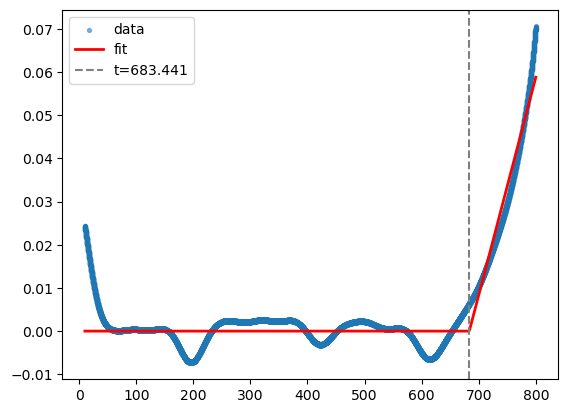

In [38]:
# fit with function
# f =c when x<t0,
# f=a(x-t0)**2+c when x>t0
slope_before_fit = slope0_filtered[starting_indx:fitting_ending_indx]
time_fitting_range = time_list_ms[starting_indx:fitting_ending_indx]
print(time_fitting_range)
# initial guesses:
a0 = 8e-6
t0 = 600             # t0 initial guess around 100ms
# c0 = np.mean(pressure_before_fit[:100]) # first 100 data average
p0 = [a0, t0]

# optionally set bounds: a>=0 , t within x-range, c in pressure range
bounds = ([0, min(time_fitting_range)], [np.inf, max(time_fitting_range)])
print(bounds)

res = least_squares(residuals_with_t, p0, args=(time_fitting_range,  slope_before_fit), bounds=bounds)
a_fit, t_fit = res.x
print("fitted a, t:", a_fit, t_fit)

# plot
plt.scatter(time_fitting_range,  slope_before_fit, s=8, alpha=0.5, label='data')
xs = np.linspace(min(time_fitting_range), max(time_fitting_range), 500)
plt.plot(xs, piecewise_with_t((a_fit, t_fit), xs), 'r-', lw=2, label='fit')
plt.axvline(t_fit, color='gray', linestyle='--', label=f't={t_fit:.3f}')
plt.legend()